<a href="https://colab.research.google.com/github/taravatp/Predicting_Future_Frames_Using_Retrospective_Cycle_GAN_pytorch/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
cd /content/drive/MyDrive/retrospective cycle GAN

/content/drive/MyDrive/retrospective cycle GAN


In [ ]:
!pip install import_ipynb 

In [ ]:
!pip install ffmpeg

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

import glob
import pickle as pkl
import import_ipynb

from IPython.display import HTML
from base64 import b64encode

from dataset_prepration.Dataset import UCF
from models import Generator,Discriminator

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Generating prediction

In [7]:
model_path = '/content/drive/MyDrive/retrospective cycle GAN/Generator49.pth'
test_generator = Generator(12).to(device)
test_generator.load_state_dict(torch.load(model_path))
print('model loaded')

model loaded


In [8]:
def make_prediction(model, index, dataset):

  sample = dataset[index]
  model_input = sample[0:12,:,:]
  model_input = torch.tensor(model_input).to(device)
  target = sample[12:15,:,:]
  
  predicted = model(model_input)


  cols = 6
  figure, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20, 12))
  model_input = model_input.cpu().numpy()
  target = target.cpu().numpy()
  predicted = predicted.cpu().detach().numpy()

  for col in range(cols):
    if col == 5:
      target = target.transpose(1,2,0)
      target = (target+1) * 127.5
      target = target.astype('uint8')
      ax[col].imshow(target)
      ax[col].set_title(f'Ground Truth Image')

    elif col == 4 :
      predicted = predicted.transpose(1,2,0)
      predicted = (predicted+1) * 127.5
      predicted = predicted.astype('uint8')
      ax[col].imshow(predicted)
      ax[col].set_title(f'predicted')

    else:

      image = model_input[col*3:(col*3)+3,:,:]
      image = image.transpose(1,2,0)
      image = (image+1) * 127.5
      image = image.astype('uint8')
      ax[col].imshow(image)
      ax[col].set_title(f'image{col}')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


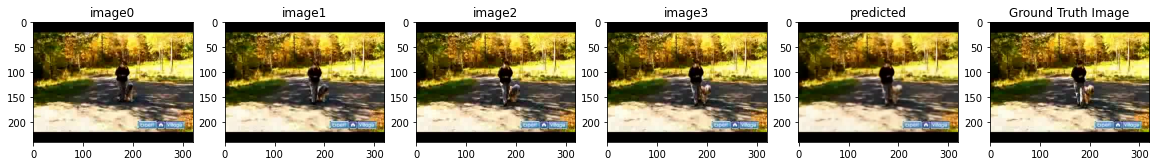

In [9]:
test_dataset = UCF(flag='train')
make_prediction(test_generator,4,test_dataset)

# Generating the ground truth video

In [ ]:
test_dataset = UCF(flag='train')
time_step = 100
out = cv2.VideoWriter('groundTruth_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 4, (320, 240))

for i in range(time_step):
    target = test_dataset[i][12:15,:,:]
    target = target.numpy()
    target = target.transpose(1,2,0)
    target = (target+1) * 127.5
    target = target.astype('uint8')
    target = cv2.cvtColor(target, cv2.COLOR_RGB2BGR)
    out.write(target)
    
out.release()

In [ ]:
!ffmpeg -i '/content/drive/MyDrive/retrospective cycle GAN/groundTruth_video.avi' '/content/drive/MyDrive/retrospective cycle GAN/groundTruth_video.mp4'

In [ ]:
mp42 = open('/content/drive/MyDrive/retrospective cycle GAN/groundTruth_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp42).decode()

HTML("""
<video width=320 height=240 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Generating the predicted video

In [ ]:
!ffmpeg -i '/content/drive/MyDrive/retrospective cycle GAN/output_video.avi' '/content/drive/MyDrive/retrospective cycle GAN/output_video.mp4'

In [ ]:
mp4 = open('/content/drive/MyDrive/retrospective cycle GAN/output_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=320 height=240 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Calculating PSNR

In [ ]:
test_dataset = UCF(flag='train')

In [ ]:
psnr = 0
for sample in test_dataset:

  model_input = sample[0:12,:,:]
  model_input = torch.tensor(model_input).to(device)

  target = sample[12:15,:,:]
  predicted = test_generator(model_input)

  target = target.numpy()
  target = target.transpose(1,2,0)
  target = (target+1) * 127.5
  target = target.astype('uint8')

  predicted = predicted.detach().cpu().numpy()
  predicted = predicted.transpose(1,2,0)
  predicted = (predicted+1) * 127.5
  predicted = predicted.astype('uint8')

  MSE = np.mean((target - predicted) ** 2)
  if MSE == 0:
    psnr += 100
  else:
    psnr += (20 * math.log10(255/math.sqrt(MSE)))

print('PSNR= ',psnr/len(test_dataset))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


PSNR=  31.508161124729114
